# Image Compression using KNN

### Definition:

* __KNN (K-Nearest Neighbour)__ algorithm is a Supervised Learning algorithm that is used to group elements into clusters. This is also known as a __lazy learner__ as it does not create a generalized model,but stores the entire dataset and when a new prediction is to be made, all computations are made only during prediction leading to high computation costs.


* Here K refers to the No of clusters(cluster centroids). 



### Steps:

1. Specify K.
2. Initialize randomly the values for K.
3. For each observation, calculate L2 Norm and assign the observation to the nearest cluster centroid.
4. Calculate Average of the cluster and assign the average as the new Cluster Centroid.
5. Repeat steps 3-4 until the Cluster Centroids Converge.


### Importing Neccesary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.io import imread, imshow
from math import log10,log2, sqrt,ceil

### Setting Cluster choices

In [2]:
K_VALUES = [2, 4, 8, 16, 32]

### Loading Image and Preprocessing

In [3]:
img_1="Data/eiffel_tower.jpg"

We will __Load and Normalize__ the image, which is a necessary step in ML with images.

In [4]:
original_image = imread(img_1)
original_image_float = original_image.astype(np.float32) / 255.0
height, width, depth = original_image_float.shape
ORIGINAL_SIZE_BYTES= height*width*depth
TOTAL_PIXELS=height*width
print(f"Image loaded: {height}x{width} pixels.")

Image loaded: 853x1280 pixels.


### Color Quantization Process

* In color quantization process, instead of storing every pixel colour values we specify clusters and using knn we find an average colour value for each clusters.
* Then when we create a compressed image, we assign each pixel of the original image to a cluster centroid and thus now we only want to store the cluster label to which a pixel belongs.
* Now only K colours (Cluster Centroid Values) are needed to construct the compressed image.

* When we construct a compressed image, the pixel colours are the values of their respective cluster centroids.
* So, now the file size is reduced

### Warning !
        * This process is a lossy compression, we lose details of the image during compression.

In [5]:
def color_quantize(image_data, k):
    
    h, w, d = image_data.shape
    pixel_data = image_data.reshape((h * w, d))
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(pixel_data)
    labels = kmeans.predict(pixel_data) 
    new_pixel_data = kmeans.cluster_centers_[labels]
    quantized_image = new_pixel_data.reshape((h, w, d))
    return quantized_image.astype(image_data.dtype)

### Estimating File size for formats like PNG/GIF

In [6]:
def estimate_file_size(k, original_bytes, total_pixels):
    indexed_bits = ceil(log2(k)) 
    indexed_size_bytes = (total_pixels * indexed_bits) / 8 
    original_bits_per_pixel = 24
    compression_ratio = original_bits_per_pixel / indexed_bits
    estimated_size = (original_bytes * indexed_bits) / original_bits_per_pixel
    
    return estimated_size / 1024 

### Calculating The Loss(MSE) and PSNR( Peak Signal to Noise Ratio)

In [7]:
def calculate_psnr(original, compressed):
    
    original_flat = original.flatten()
    compressed_flat = compressed.flatten()
    mse = np.mean((original_flat - compressed_flat) ** 2)
    
    if mse == 0:
        return float('inf'), 0.0
    
    MAX_I = 1.0
    psnr = 10 * log10(MAX_I**2 / mse)
    loss_percentage = mse * 100 
    return psnr, loss_percentage

### Plotting of Results

Compressing using K=2...
Compressing using K=4...
Compressing using K=8...
Compressing using K=16...
Compressing using K=32...


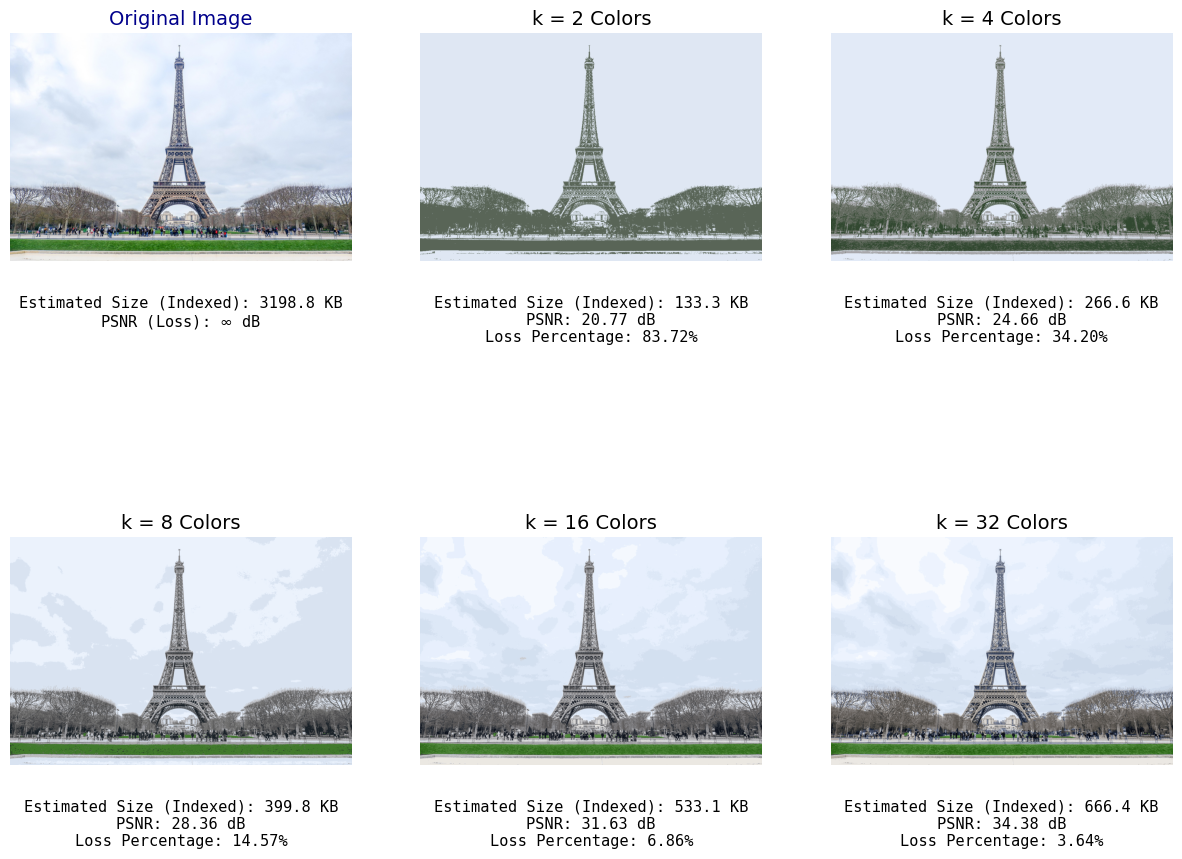

In [8]:
if original_image_float is not None:
    num_plots = len(K_VALUES) + 1
    cols = 3
    rows = (num_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
    axes = axes.flatten()
    original_size_kb = ORIGINAL_SIZE_BYTES / 1024

    axes[0].imshow(original_image)
    axes[0].set_title("Original Image", fontsize=14, color='darkblue')
    axes[0].axis('off')
    axes[0].text(0.5, -0.15, 
                 f"Estimated Size (Indexed): {original_size_kb:.1f} KB\nPSNR (Loss): $\infty$ dB", 
                 horizontalalignment='center', verticalalignment='top', 
                 transform=axes[0].transAxes, fontsize=11, family='monospace')
    
    plot_index = 1
    
for k in K_VALUES:
    print(f"Compressing using K={k}...",flush=True)
    compressed_image = color_quantize(original_image_float, k)
    psnr, loss_percent = calculate_psnr(original_image_float, compressed_image) 
    estimated_size = estimate_file_size(k, ORIGINAL_SIZE_BYTES, TOTAL_PIXELS)
    
    axes[plot_index].imshow(compressed_image)
    axes[plot_index].set_title(f"k = {k} Colors", fontsize=14)
    axes[plot_index].axis('off')
    axes[plot_index].text(0.5, -0.15, 
                          f"Estimated Size (Indexed): {estimated_size:.1f} KB\nPSNR: {psnr:.2f} dB\nLoss Percentage: {loss_percent*100:.2f}%", 
                          horizontalalignment='center', verticalalignment='top', 
                          transform=axes[plot_index].transAxes, fontsize=11, family='monospace')
    
    plot_index += 1

* __Here we can observe that with increasing no.of clusters, the loss decreases and file size increases.__